# 実装演習 4-1. RNN

In [1]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## データ用意
2進数の予測値を実データに近づけていく

In [2]:
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis=1)

input_layer_size = 2  # 入力層の数
hidden_layer_size = 16  # 隠れ層の数
output_layer_size = 1  # 出力層の数

weight_init_std = 1  # 初期ウェイト
learning_rate = 0.1  # 学習率

iters_num = 10000  # 繰り返し回数
plot_interval = 100  # グラフへのプロット間隔

In [3]:
# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

In [4]:
# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

In [5]:
u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

## 学習

In [5]:
for i in range(iters_num):
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number / 2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number / 2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[-t - 1], b_bin[-t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:, t+1] = np.dot(X, W_in) + np.dot(z[:, t].reshape(1, -1), W)
        z[:, t+1] = functions.sigmoid(u[:, t+1])

        y[:, t] = functions.sigmoid(np.dot(z[:, t+1].reshape(1, -1), W_out))

        # 誤差関数はMSEを使用する
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:, t] = functions.d_mean_squared_error(dd, y[:, t]) * functions.d_sigmoid(y[:, t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:, t])
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:, t+1].T, W.T) + np.dot(delta_out[:, t].T, W_out.T)) * functions.d_sigmoid(u[:, t+1])

        # 勾配の更新
        W_out_grad += np.dot(z[:, t+1].reshape(-1,1), delta_out[:, t].reshape(-1, 1))
        W_grad += np.dot(z[:, t].reshape(-1, 1), delta[:, t].reshape(1, -1))
        W_in_grad += np.dot(X.T, delta[:, t].reshape(1, -1))
    
    # 更新された勾配を適用する
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    # 更新用の勾配を初期化
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    
    # 途中経過の出力
    if i % plot_interval == 0:
        all_losses.append(all_loss)
        
        print(f"iters: {i}")
        print(f"Loss: {all_loss}")
        print(f"Pred: {out_bin}")
        print(f"True: {d_bin}")
        
        out_int = 0
        
        for index, x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        
        print(f"{a_int} + {b_int} = {out_int}")
        print("-"*20)

iters:0
Loss:1.469399340903874
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 1 0 0]
125 + 39 = 0
------------
iters:100
Loss:1.3968157974462927
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 1 0 1]
73 + 20 = 0
------------
iters:200
Loss:0.9470550270404142
Pred:[0 0 1 0 1 1 1 0]
True:[1 0 0 0 0 0 1 0]
20 + 110 = 46
------------
iters:300
Loss:0.898586917981236
Pred:[0 0 1 1 1 1 1 0]
True:[0 0 1 0 1 0 1 0]
12 + 30 = 62
------------
iters:400
Loss:0.8959399431187767
Pred:[1 1 1 0 0 1 1 1]
True:[1 1 0 0 0 1 1 0]
99 + 99 = 231
------------
iters:500
Loss:1.0006066872760597
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 0 1 0]
121 + 41 = 0
------------
iters:600
Loss:1.2948714529648264
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 1 0 0 0 0]
25 + 87 = 255
------------
iters:700
Loss:0.7563806366283264
Pred:[0 0 0 1 0 0 0 0]
True:[0 1 0 1 1 0 0 0]
8 + 80 = 16
------------
iters:800
Loss:0.9094656360238291
Pred:[0 0 1 0 0 0 0 1]
True:[1 0 1 0 1 0 1 1]
90 + 81 = 33
------------
iters:900
Loss:0.7902618074464609
Pred:[1 0 0 0 0

------------
iters:7600
Loss:0.0023816357986003794
Pred:[1 0 1 1 1 1 1 0]
True:[1 0 1 1 1 1 1 0]
106 + 84 = 190
------------
iters:7700
Loss:0.0019451505057010458
Pred:[1 0 1 0 1 1 1 1]
True:[1 0 1 0 1 1 1 1]
105 + 70 = 175
------------
iters:7800
Loss:0.0009882165073894637
Pred:[1 1 0 1 1 0 0 0]
True:[1 1 0 1 1 0 0 0]
95 + 121 = 216
------------
iters:7900
Loss:0.0015429192681856493
Pred:[1 1 0 0 0 0 1 1]
True:[1 1 0 0 0 0 1 1]
78 + 117 = 195
------------
iters:8000
Loss:0.0005543140910712863
Pred:[1 0 0 1 1 0 1 0]
True:[1 0 0 1 1 0 1 0]
107 + 47 = 154
------------
iters:8100
Loss:0.0014387731699986258
Pred:[0 1 1 0 0 1 0 1]
True:[0 1 1 0 0 1 0 1]
79 + 22 = 101
------------
iters:8200
Loss:0.001769254547193303
Pred:[0 0 0 1 0 1 0 0]
True:[0 0 0 1 0 1 0 0]
12 + 8 = 20
------------
iters:8300
Loss:0.0017749199814349195
Pred:[0 0 1 1 1 0 0 0]
True:[0 0 1 1 1 0 0 0]
34 + 22 = 56
------------
iters:8400
Loss:0.0006126589699232333
Pred:[0 1 1 0 0 0 1 0]
True:[0 1 1 0 0 0 1 0]
7 + 91 = 98
--

## グラフの描画

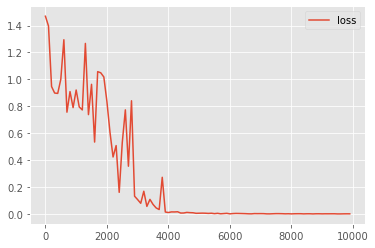

In [9]:
lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.legend()
plt.show()

## 考察
iters:1600あたりで予測値が正解と一致するようになり、iters:2100あたりから正解値とよく一致するようになった。 <br/>
iters:3000あたりからは、かなりの精度で正解と一致するようになった。 <br />
lossのグラフを見ても、iters:3000あたりからは0.1未満になるようになった。